## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

The Neural network in ChatGPT (Generatively Pretrained Transformer) is the Transformer architecture from "Attention is all you need" with very small modification.
Training a production grade system, fine tuning with human feed back are all extreme engineering challenges which ChatGPT solved.

How ChatGPT works under the hood with an example?
For pedagogical reasons, Andrej chose Shakespear's writing in his course. Tiny shakespeare is a 1MB file which compiles all works of shakespear.

Goal is to build a model that can produce Shakespere like text. Lets build a model from scratch into a Transformer architecture. Nerual network is expected to model all the patterns in this data and learn to produce character sequences that look like Shakespear's work.

ChatGPT produces subword (chunk of word) after subword. While we will produce char after char in this exercise.

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-06-02 20:58:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2023-06-02 20:58:28 (32.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# Tokenize: encoding the characters into a list of integers.
# We have an Encoder and Decoder.
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Many other schemas to tokenize: Google uses SentencePiece and OpenAI uses tiktoken. GPT uses tiktoken.

Its a sub word tokenizer. Neither an entire word nor a character.
With sub words instead of characters, we will have fewer integers representing the same string. But the number of subwords you can have in the vocabulary list is large.

Tradeoff between - Length of squence of integers and vocab size

In [ ]:
! pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00


In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
print(enc.n_vocab) # number of tokens
print(enc.encode("hi there"))
print(enc.decode([5303, 612]))
# You can see that "hi there" requires just two integers to get encoded.

50257
[5303, 612]
hi there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor

import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earlier will look like this to the GPT

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:] # hide the validation data

In [ ]:
# Data is usaually trained in small chunks. Here its called Block_size or context_length.
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
# All the 8 individual examples are trained at once by the transformer.
# Model is trained to predict the output after seeing as little as one length of context to a block_size length of context.
# Useful later during inference - sample with as little context length as 1 to block size. After predicting block size length of characters, start truncating.

x = train_data[:block_size]
y = train_data[1:block_size+1] # target is offset by 1
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [ ]:
torch.manual_seed(1337) # Since we are going to use random locations from the data to pull the chunks.
batch_size = 4 # How many independent sequences will we process in parallel? Keeps the GPUs busy. They don't talk to each other.
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # block size length of random offsets from the training set.
    x = torch.stack([data[i:i+block_size] for i in ix]) # 1 dimentional tensor are stacked into multiple rows.
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    print("----------new batch-------------")
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

# 32 examples in one batch. They are all independent examples.

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
----------new batch-------------
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
----------new batch-------------
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [ ]:
# Simplest neural network language model - Naive Bigram language model

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #(num of embeddings, embedding_size)
        # Each token is projected in to the embedding space to a vector of size vocab_size which is called the embedding_size.
        # original papers calls the embedding_size as 'd_model'.

    def forward(self, idx, targets):
        # idx (inputs) and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx)
        # From the 65 x 65 size look up table, every integer from the input like 24, 43  will have a corresponding 65 dim vector. Its the identity of that single token.
        # Pytorch is going to arrange them in a a stack of dimension - (B,T,C) (4, 8, 65)
        # Output of the embedding table is interpretted as logits/scores by the model. Each token is seeing only themself.
        # Each token directly reads off the logits for the next token from a lookup table.
        # I am looking at only this token to predict the next token - some chars follow other chars in typical scenarios.

        return logits

m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

torch.Size([4, 8, 65])


In [ ]:
# Now lets measure the loss of this model. Neg log likelihood loss (named CrossEntropy in pytorch)

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # $$ each token directly reads off the logits for the next token from a lookup table $$
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # (vocab_size, embedding_size)
        # Embedding size neednt not be vocab size. But output dimension must be the size of the vocab size.
        # We will see that later how we will manage a different size embedding.

    def forward(self, idx, targets):
        # idx (inputs) and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C) (4, 8, 65) Output of the embedding table is interpretted as logits/scores by the model. Each token is seeing only themself.

        B, T, C = logits.shape
        logits = logits.view(B*T, C) # In the C (65) dimensional vector, value corresponding to next char must carry higher magnitude than the rest of the values of characters.
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets) # Loss determines, how well are we predicting the next char?

        return logits, loss

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [ ]:
# Now lets generate from the above model.
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # $$ each token directly reads off the logits for the next token from a lookup table $$
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx (inputs) and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C) (4, 8, 65) Output of the embedding table is interpretted as logits/scores by the model. Each token is seeing only themself.
        # Embedding size neednt not be vocab size. But output dimension must be the size of the vocab size. We will see how to manage this later.

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # In the C dimensional vector, value corresponding to next char must carry higher magnitude than the rest of the values of characters.
            targets = targets.view(B*T) # One dimention - not dimension.
            loss = F.cross_entropy(logits, targets) # how well are we predicting the next char

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        # Job of generator is to take BXT and generate BX(T+1) and this repeats.
        for _ in range(max_new_tokens):
            # get the predictions
            # calls the forward function above
            # Make targets = None because we are not sending targets while generating.
            # No loss when targets = None.
            logits, loss = self(idx)
            # focus only on the last time step - only that represents the predictions.
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# Batch size 1, time size 1. 1x1 tensor will hold a 0. This is how we kick off the generation. 0 is the element standing for a new line char.
# Can have higher batch size and longer sequence length as well.
idx = torch.zeros((1, 1), dtype=torch.long)
# Ask for 100 tokens.
print(m.generate(idx, max_new_tokens=100))
# Decode the tokens into characters.
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))
# Full garbage because its totally random model.
# Right now to predict a char its only looking at the previous char. What if it can look into longer context length.

torch.Size([256, 65])
tensor(4.8250, grad_fn=<NllLossBackward0>)
tensor([[ 0, 31, 56, 12, 55, 28,  7, 29, 35, 49, 58, 36, 53, 24,  4, 48, 24, 16,
         22, 45, 27, 24, 34, 64,  5, 30, 21, 53, 16, 55, 20, 42, 46, 57, 34,  4,
         60, 24, 24, 62, 39, 58, 48, 57, 41, 25, 54, 61, 24, 17, 30, 31, 28, 63,
         39, 53,  8, 55, 44, 64, 57,  3, 37, 57,  3, 64, 18,  7, 61,  6, 11, 43,
         17, 49, 64, 62, 48, 45, 15, 23, 18, 15, 46, 57,  2, 47, 35, 35,  8, 27,
         40, 64, 16, 52, 62, 13,  1, 25, 57,  3,  9]])

pdcbf?pGXepydZJSrF$Jrqt!:wwWSzPNxbjPiD&Q!a;yNt$Kr$o-gC$WSjJqfBKBySKtSKpwNNfyl&w:q-jluBatD$Lj;?yzyUca


In [ ]:
# create a PyTorch optimizer object.
# Adam is an advanced version of SGD (stochastic gradient descent)
# updates the parameters using the gradient.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
# Typical training loop.
batch_size = 32 # Earlier it was 4.
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True) # zero out the gradients from the previous step.
    loss.backward() # compute the loss
    optimizer.step() # change the parameters

print(loss.item())


2.556438684463501


In [ ]:
# Its not going to be shakespear. Its a bigram model!!
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


CH;
Ane his, t, f at. fal whetrimy bupof tor atha Bu!
JOutho f cimimave.
NEDUSt cir selle p wie wede
Ro n apenor f'Y tover witys an sh d w t e w!
CEOntiretoaveE IINpe, theck. cung.
ORIsthies hacin benqurd bll, d a r w wistatsowor ath
Fivet bloll ang a-I theeancu,
LINCI'T:
Sarry t I Ane sze t
LCKI thit,
n.
Faure ds ppplirn!
meftou ow uring, avewist th;
TENTEMETCI gienco, An he waro whiougou he s imaror?
Bu ne-ingof acat nd l,
Fothind aty y:
ARDUTA llllld!
AMQUThes med thestw cos wand herf s hafol


Hurray!! Dramatic improvement! That is the simplest possible model.These tokens have to talk to each other to be able to make better prediction.

## The mathematical trick in self-attention

In [ ]:
# consider the following toy example:
torch.manual_seed(1337)
B,T,C = 4,3,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 3, 2])

I should only be able to look at the past tokens.
How do you incorporate the past information - one way is averaging the past (cons: lossy - spatial info is lost). Nevertheless lets implement it.

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) #bag of words

for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C) in this batch dimension, every thing upto and in the location t.
        xbow[b,t] = torch.mean(xprev, 0) # averaging the t.

print(x[0])
print(xbow[0])
print(((0.1808 + -0.3596)/2))
print((0.1808 + -0.3596 +  0.6258)/3)

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199]])
-0.0894
0.14900000000000002


In [ ]:
# For loop is n**2 expensive. so lets matrix multiply.
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
# a = torch.ones(3, 3)
a = torch.tril(torch.ones(3, 3)) # lower triangular matrix with ones. upper traiangular elements will be 0
print(a)
a = a / torch.sum(a, 1, keepdim=True) # If the rows sum to 1. Averages are done in incremental fashion.
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
print(wei) # This is our 'a' from above example.
xbow2 = wei @ x # Pytorch will see that batch dimension is missing in wei and will create a B. Batched matrix multiply. (B, T, T) @ (B, T, C) ----> (B, T, C)
print(torch.allclose(xbow, xbow2))

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
True


T x T matrix is telling about the affinity between each token in across every time step.

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
print(tril)
wei = torch.zeros((T,T)) #intial affinity (how related each token is with previous tokens) between all tokens is set to 0
print(wei)
wei = wei.masked_fill(tril == 0, float('-inf')) # Future cannot communicate with the past.
print(wei)
wei = F.softmax(wei, dim=-1) # normalization operation, exponentiate every one of these and divide by sum.
#
print(wei)
xbow3 = wei @ x # Its weighted aggregation of previous characters. This can be achieved by matrix multiplication with lower triangular matrix.
torch.allclose(xbow, xbow3)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])


True

Over a period of training, some tokens are going to find some token more useful. that score is called affinity between each character.
This is a preview into how self attention works.

In [ ]:
# 1) Lets see how to manage when embedding_size is not equal to vocab size. This is will introduce more complexity into the model and therefore capture richer representation.
# 2) Along with identity lets add position information of the tokens

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# Hyperparameters
n_embd = 32

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # n_embd is 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # Another emdding for position.

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C) positions of T tokens will be integers from 0 to T-1. All of these tokens will ebedded into a table (T,C)
        x = tok_emb + pos_emb # (B,T,C) (B, T, C) + (T, C) will get right alligned and a new dimension gets broadcasted resulting in (B, T, C)
        # x holds not just the token identities but the positions at which the tokens occur.
        # Right now this would not matter because of translation invariance. But this will start to matter when we start with self attention block.
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # In the C dimensional vector, value corresponding to next char must carry higher magnitude than the rest of the values of characters.
            targets = targets.view(B*T) # One dimention - not dimension.
            loss = F.cross_entropy(logits, targets) # how well are we predicting the next char

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


In [ ]:
# version 4: self-attention for a single individual head!

# Ideally intial affinity between tokens shouldn not be zero - it should data dependent. Vowels is preceded by a consonant mostly. That kind of dependency.
# Self attention solves this.
# Every token will emit two vectors - query (what am I looking for) and key (what do I contain). Dot product between the two gives the affinity.
# Token i: (What am I looking for) X (What every one has to offer). If query and key of a particular values are aligned it will have a higher value.

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # size of a single head.
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# When I pass 'x' through key and query, all the tokens parallely produce some result. No communication has happened yet.
wei =  q @ k.transpose(-2, -1) # Transpose the last two dimensions : (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# Now wei is not 0 as in earlier. Some raw affinities

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # upper triangular masking
wei = F.softmax(wei, dim=-1) # exponentiate and normalize to produce a nice distribution between 0 and 1.

print(wei[0])
# The values wont be uniform because they all carry different weights.
# Example) I am vowel at 8th place and am looking for consonants in any position upto 4.
# Every token is also emitting a key
# Dot product will have a high affinity when there is a high alignment.

v = value(x)
out = wei @ v # instead of raw x, we aggregate v.
# x is a private info to the token
# For the purposes of a single head, key: here is what Iam interested in, query: here is what I have, if you are interested in me, value: here is what I will communicate to you.
#out = wei @ x

print(out.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)
torch.Size([4, 8, 16])


Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- In principle, self attention can be applied to any graph, LLMs are autoregressive so they are topological graphs - cant see future nodes.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens. Different from convolution because convolutional filters act in space. Specific layout is captured using filters.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other. 4 separate pools of 8 nodes are talking to each other.
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling. Sentiment analysis does not require to block the future - you may want to look at all the nodes.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size) # unit gaussian
q = torch.randn(B,T,head_size) # unit gaussian
wei = q @ k.transpose(-2, -1) # not unit gaussian
unit_wei = q @ k.transpose(-2, -1) * head_size**-0.5 # now unit guassian

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(17.4690)

In [ ]:
unit_wei.var()

tensor(1.0918)

Why do you want the vectors to be unit gaussian? Otherwise the values are too peaky and information will get aggregated from a single node. You can achieve unit gaussian by dividing with sqrt(head_size)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot. Aggregates info from a single node.

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
# Lets add the single head into code with all other stuff discussed above.

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#if you use gpu, things will be much faster. Remember to move the data, model parameters, context while generating to device.
eval_iters = 200
n_embd = 32
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Earlier every batch was more or less lucky. Here loss is averaged over the entire batch.
def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)

def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.sa_head(x) # apply one head of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


step 0: train loss 4.1761, val loss 4.1767
step 500: train loss 2.8334, val loss 2.8450
step 1000: train loss 2.6531, val loss 2.6548
step 1500: train loss 2.5601, val loss 2.5686
step 2000: train loss 2.5011, val loss 2.5123
step 2500: train loss 2.4706, val loss 2.4849
step 3000: train loss 2.4441, val loss 2.4663
step 3500: train loss 2.4368, val loss 2.4436
step 4000: train loss 2.4218, val loss 2.4272
step 4500: train loss 2.4076, val loss 2.4247
step 4999: train loss 2.4014, val loss 2.4167

PAMy cen cerpesad.

I perad nmesorwou mee sowot towosece m, dithif pfing bevint atish bes LRANORDUYim MRE: hod ant qour, wou
I ll.

Hate, indanil isst pont yt leven mon yu daivek.

peveng?
Bqu youed wor
Ane bstend thironeend, hes owe andingel'
Amals hst iow bly me cn the fo! k sthul miminot orurril,
Conco an sthay ser fla the ivithe y ourdd, favit ous mamy tres you Bollll ome te
F
Tor you, the che burshesos ol ind bet bitess n
Entour,' do murn y'lowno ats.

H:
I's RAURKEHom?
Pulond foke tosl,

In [ ]:
# Now lets add multiple heads

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#if you use gpu, things will be much faster. Remember to move the data, model parameters, context while generating to device.
eval_iters = 200
n_embd = 32
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Earlier every batch was more or less lucky. Here loss is averaged over the entire batch.
def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)

def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    # Virat kohli is a good batsaman. He loves pets and he has 4 dogs.
    # One head each for adjectives, adverbs, possesion etc,.
    # find vowels, consonants, vowels of different kinds etc,.

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimentional self attention. Instead of one large convolution, do convolution in groups.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.sa_heads(x) # apply 4 heads of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


step 0: train loss 4.1729, val loss 4.1759
step 500: train loss 2.7266, val loss 2.7412
step 1000: train loss 2.6221, val loss 2.6241
step 1500: train loss 2.5478, val loss 2.5533
step 2000: train loss 2.4925, val loss 2.4947
step 2500: train loss 2.4485, val loss 2.4569
step 3000: train loss 2.4046, val loss 2.4146
step 3500: train loss 2.3780, val loss 2.3806
step 4000: train loss 2.3526, val loss 2.3541
step 4500: train loss 2.3211, val loss 2.3405
step 4999: train loss 2.3047, val loss 2.3177

PAMy con cerpedad. be pary tumesorw oumee so,
Futowos cerm, dithif ifiih bevinthe ath be nouldas seid Momf hod ank qouras on
I lobagened,t, lanil isst ponty theeven monky weaivek.


LWhat?
Bqu yourd tor
Ain bisend thironGend,
O shoue and hace comals brt mowmlls mand ur,
Tur! k sotul mims fid tharilenct preands,
Nads er la the man aedy our dadimon mous momy tres you Bmllllenm?

WEnd ozurit, the cay ger.

QUimy, ind I
Cithatss neccto f,'d the onoy towno atsing,
And'k ves force.
G, wold sturthl,

In [ ]:
# Lets add a feed forward network : happens per token. Now that we have gathered all the data, each token has to think individually.
# Now lets focus on increasing the compute power - put all the above in a block and increase the number of blocks
# Deeper neural networks lead to optimization problems, so add a skip/residual connection - gradient flows uninterupted.


import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#if you use gpu, things will be much faster. Remember to move the data, model parameters, context while generating to device.
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Earlier every batch was more or less lucky. Here loss is averaged over the entire batch.
def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)

def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # residual connection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # to reciprocate the paper.
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # projection layer going to back into the residual pathway.
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        # self.ln1 = nn.LayerNorm(n_embd)
        # self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        # x = x + self.sa(self.ln1(x))
        # x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        # x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.208577 M parameters
step 0: train loss 4.7239, val loss 4.7112
step 500: train loss 2.2549, val loss 2.2698
step 1000: train loss 2.0554, val loss 2.0964
step 1500: train loss 1.9158, val loss 2.0238
step 2000: train loss 1.8418, val loss 1.9580
step 2500: train loss 1.7957, val loss 1.9378
step 3000: train loss 1.7543, val loss 1.9007
step 3500: train loss 1.7289, val loss 1.8781
step 4000: train loss 1.7116, val loss 1.8595
step 4500: train loss 1.6906, val loss 1.8412
step 4999: train loss 1.6576, val loss 1.8281


MENENIUS:
Servant thy dlater!
Cangelo, but toget it-morry Bothath leage man his flove face,
That you
let!'Lancious begags;
Or never this lear; and well, and be seep? That fatherly
that that all cared friend, and unce once,
That I sweat thring of thee femjsely!
Which not gladent kny hef hath listly.

KING RICHARD III:
And gry add, gire all he hath my his coure to seigning and tress, haw, both been of them;
And hath some only grace thus you advy restock on eyet,
Os toloth

In [ ]:
# Batch norm made sure that every neuron across the batch had unit variance and zero mean.
# Layer norm makes sure that unit variance is maintained within each sample across all the features.

class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean. In batch norm its x.mean(0, keepdim=True)
    xvar = x.var(1, keepdim=True) # batch variance.  In batch norm its x.var(0, keepdim=True)
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs. Had we implemented batch norm, the answer would have be 0 mean and 1 var.

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, across all its features. Since we implemented Layer norm above, the ans is 0 mean and 1 var.

(tensor(-9.5367e-09), tensor(1.0000))

We dont have to maintain any running buffers because we can apply this any time. unlike in batch norm. running mean and running var were useful during inference.

In [ ]:
# Finally we add layer norm and dropout is also there to regularize.

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#if you use gpu, things will be much faster. Remember to move the data, model parameters, context while generating to device.
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Earlier every batch was more or less lucky. Here loss is averaged over the entire batch.
m
def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)

def estimate_loss():
    out = {}
    model.eval() # some layers will have different behaviour in inference time or triaing time. so this is an important setting.
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 500: train loss 2.3135, val loss 2.3140
step 1000: train loss 2.1010, val loss 2.1278
step 1500: train loss 1.9656, val loss 2.0322
step 2000: train loss 1.8791, val loss 1.9671
step 2500: train loss 1.8184, val loss 1.9448
step 3000: train loss 1.7718, val loss 1.9150
step 3500: train loss 1.7468, val loss 1.8973
step 4000: train loss 1.7210, val loss 1.8616
step 4500: train loss 1.6955, val loss 1.8490
step 4999: train loss 1.6635, val loss 1.8248


My haligio:
That agisg love I say all her defer mis-morry love altieng; my mentwell:
As he, what you lat! Hancomming thought.

POMPEDY IVELLAURENT:
But, and be seep? That face will.
We will all care dedise.

For God Henry, will of what; is for hows and myself!
Which nother he's king! fallowelts have, vert by her
A first they addly joness and he is man;
Now ever their Seriand of suffend, ontught Backingmins!

MENENIUS:
Comlecary'd from yourselver, woar sonestly that a'tw

This is a transformer is trained only on 1 mil paramters. Blabbers like shakespere like manner. Pretty good demonstration of what is possible.

This is only a decoder only block from the "Attention is all you need paper"
Only decoder because its using a triangular mask.

Original paper is a machine translation paper - so its a encoder-decoder model. It conditions the generation on some additional information (French) and generate text in English.
French to English translation example:

<--------- ENCODE ------------------><--------------- DECODE ----------------->
les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

All tokens are allowed to talk as much as they want. To solve problems like Sentimentent analysis also, each token is allowed to talk to everyone (past and future).

What it takes to build a ChatGPT? How does it relate to what we saw today?
1 Pretraining Stage: Training on a large chunk of internet and get a decoder only transformer to babble text. Very similar to what we saw now. Ours is a tiny baby.
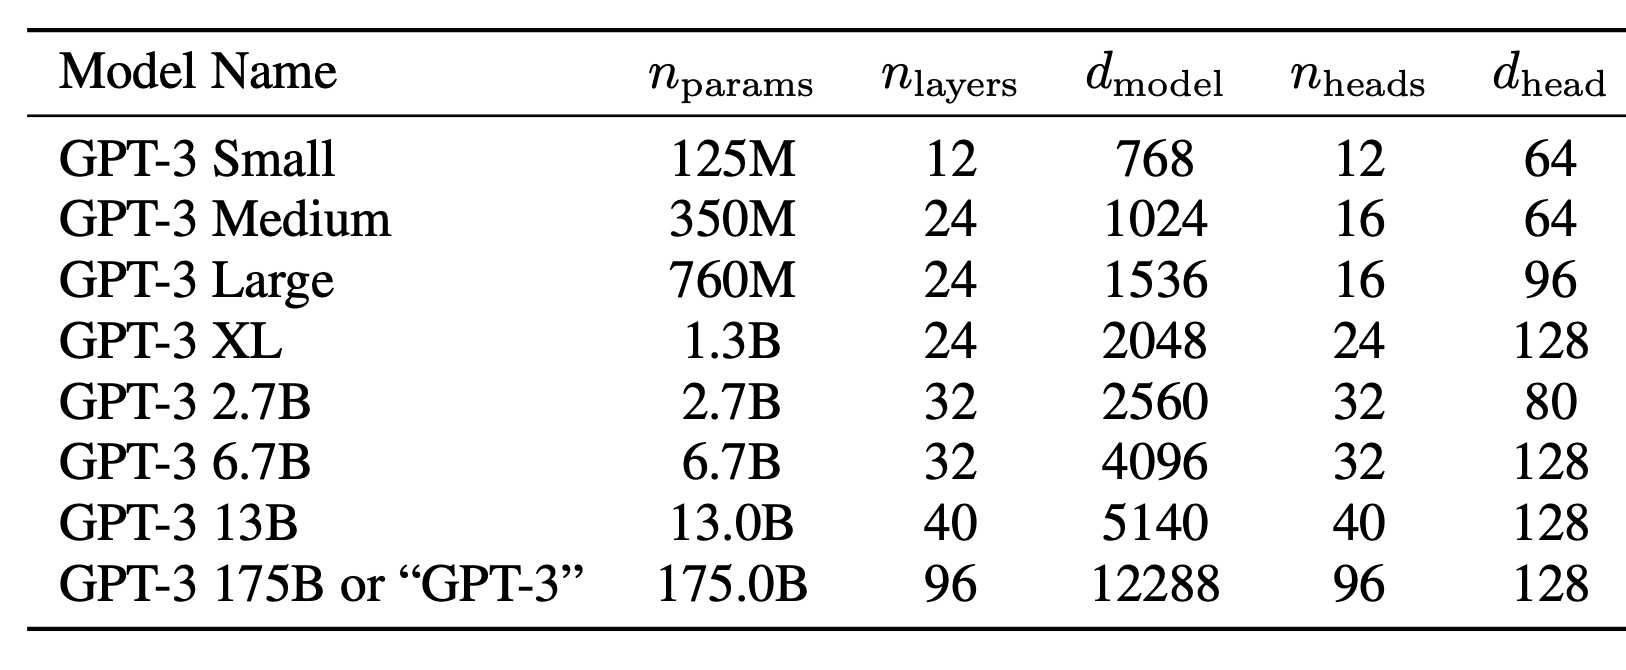

In our case:

n_params - 1 Million

n_layers - number of blocks - 4

d_model - embedding_size - 32

n_heads - number of heads in multi head attention - 4

d_head - head_size - 16

number_of_tokens -1 Million, ChatGPT number_of_tokens must be a few Trillion by now.



# ChatGPT
(State 1) Pretraiing part which will learn to generate documents of internet using the architecture just discussed. Architecture is similar with massive infrastructure challenge. 1000s of GPUs talking to each other.

(Stage 2) Finetuning Stage: Allign it to be an assistant.
Step 1 - few question answers training.
Step 2 - rank the answers
Step 3 - Policy gradient - chatgpt is expected to score a high number.